In [5]:
from datetime import datetime
import numpy as np             #for numerical computations like log,exp,sqrt etc
import pandas as pd            #for reading & storing data, pre-processing
import matplotlib.pylab as plt #for visualization
#for making sure matplotlib plots are generated in Jupyter notebook itself
%matplotlib inline             
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf

##分解(decomposing) 可以用来把时序数据中的趋势和周期性数据都分离出来:
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6

In [6]:
Data = pd.read_csv('./world.csv', index_col=0)#1月20日-3月18日 世界总确诊人数
#增加id递增列
Data = Data.reset_index()
##该步骤很重要！！建立时序数据
#Parse strings to datetime type  将字符串解析为datetime类型
#convert from string to datetime ###Name: date, dtype: datetime64[ns]
Data['日期']= pd.to_datetime(Data['日期'],infer_datetime_format=True) 
#set_index( ) 将 DataFrame 中的列转化为行索引
indexedDataset = Data.set_index(['日期'])
#数据反转
indexedDataset = indexedDataset.iloc[::-1]
indexedDataset


,confirmedCount
日期,
2020-01-20,282
2020-01-21,314
2020-01-22,581
2020-01-23,844
2020-01-24,1312
2020-01-25,2015
2020-01-26,2801
2020-01-27,4579
2020-01-28,6061


D:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


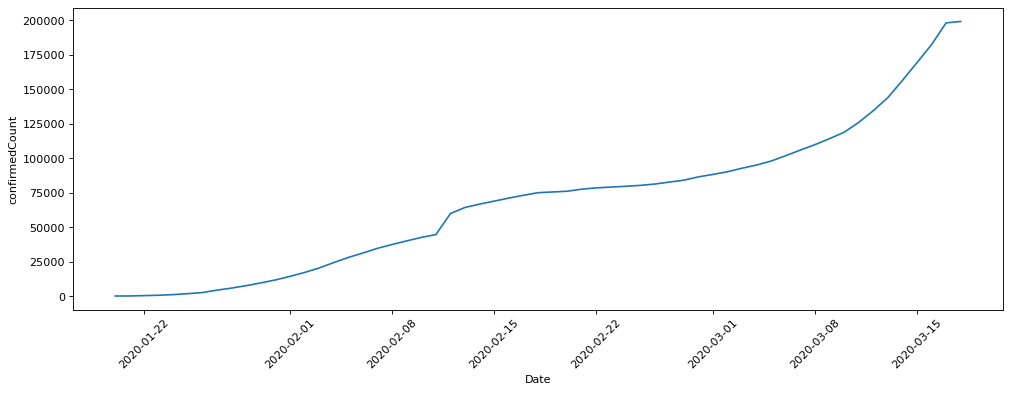

In [8]:

# plot graph
#设置画布大小
plt.figure(figsize=(15,5),dpi = 80)
#横轴坐标旋转45°
plt.xticks(rotation=45)


plt.xlabel('Date')
plt.ylabel('confirmedCount')
plt.plot(indexedDataset)

### 三、时序数据变换，获得稳定性数据  

#### 3.1构建稳定性检验函数：  
    #滑动平均值  
    #滑动标准差  
    #Augmented Dickey–Fuller ADF稳定性检验

In [9]:
#构建稳定性检验函数
def test_stationarity(timeseries):  
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()  #滑动平均值
    movingSTD = timeseries.rolling(window=12).std()     #滑动标准差
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.xticks(rotation=45)
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:   Augmented Dickey–Fuller ADF稳定性检验
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['confirmedCount'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

#### 3.2  Differencing差分方法-Timeshift transformation

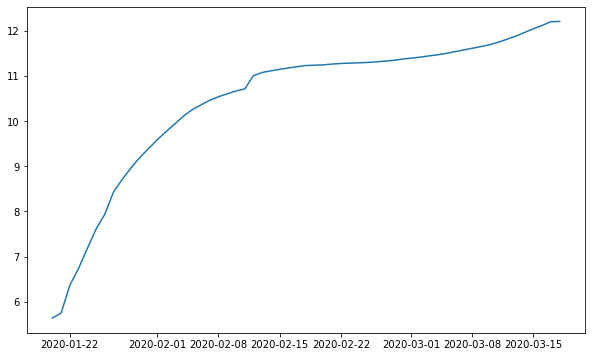

In [10]:
#Estimating trend 估计趋势
indexedDataset_logScale = np.log(indexedDataset)  #taking log 
plt.plot(indexedDataset_logScale)

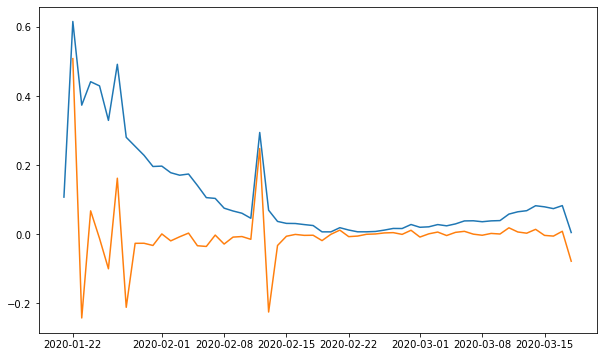

In [11]:
##Differencing--差分
##这里采用的是一阶差分：一阶差分就是离散函数中连续相邻两项之差。
datasetLogDiffShifting_1 = indexedDataset_logScale - indexedDataset_logScale.shift()
plt.plot(datasetLogDiffShifting_1)

#二阶差分：二阶差分就是一阶差分再进行一次差分。
#注：以下内容可以看出，二阶差分后数据已经稳定，所以ARIMA模型参数d=2。
datasetLogDiffShifting_2 = datasetLogDiffShifting_1 - datasetLogDiffShifting_1.shift()
plt.plot(datasetLogDiffShifting_2)

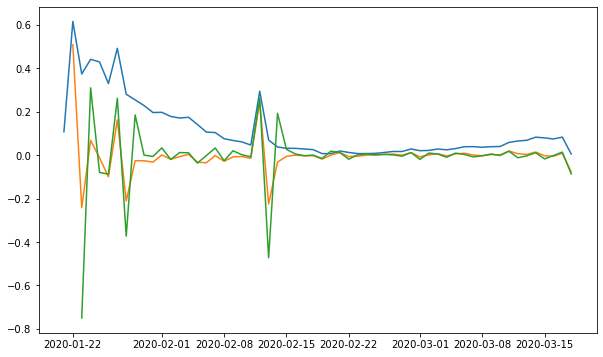

In [12]:
example1 = indexedDataset_logScale.diff(1)
plt.plot(example1)
example2 = example1.diff(1)
plt.plot(example2)
example3 = example2.diff(1)
plt.plot(example3)

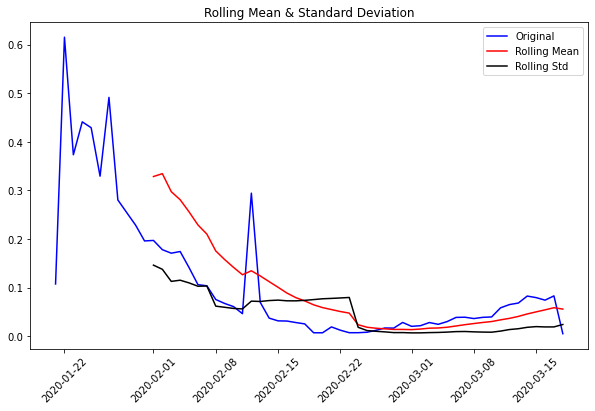

Results of Dickey Fuller Test:
Test Statistic                 -2.847150
p-value                         0.051848
#Lags Used                      2.000000
Number of Observations Used    55.000000
Critical Value (1%)            -3.555273
Critical Value (5%)            -2.915731
Critical Value (10%)           -2.595670
dtype: float64


In [13]:
datasetLogDiffShifting_1.dropna(inplace=True)#滤除缺失数据。
test_stationarity(datasetLogDiffShifting_1)

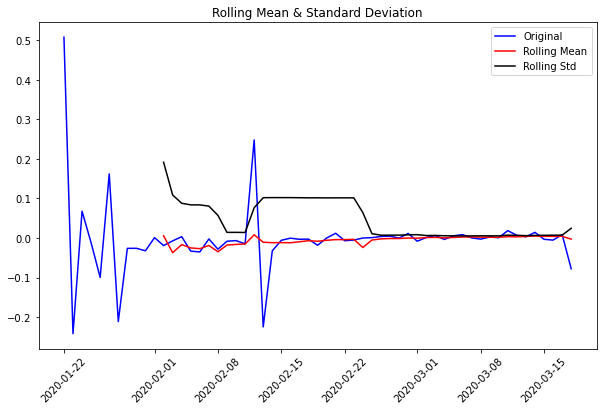

Results of Dickey Fuller Test:
Test Statistic                -8.336685e+00
p-value                        3.258054e-13
#Lags Used                     1.000000e+00
Number of Observations Used    5.500000e+01
Critical Value (1%)           -3.555273e+00
Critical Value (5%)           -2.915731e+00
Critical Value (10%)          -2.595670e+00
dtype: float64


In [14]:
datasetLogDiffShifting_2.dropna(inplace=True)#滤除缺失数据。
test_stationarity(datasetLogDiffShifting_2)

差分后平稳性都要比原数据好很多。

### 四、构建模型
#### 4.1 自相关图和偏自相关图的分析

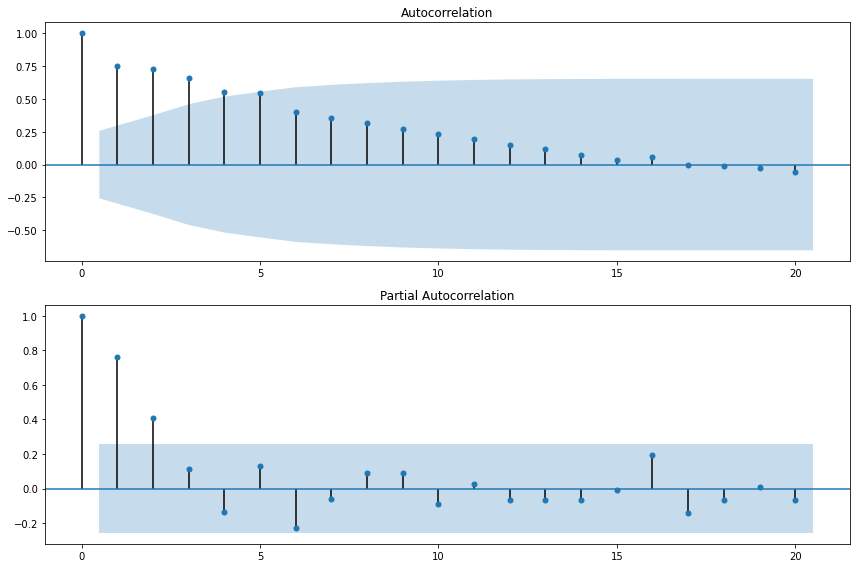

In [15]:
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))

#acf   from statsmodels.tsa.stattools import acf, pacf
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(datasetLogDiffShifting_1, lags=20,ax=ax1)
ax1.xaxis.set_ticks_position('bottom')
fig.tight_layout();

#pacf
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(datasetLogDiffShifting_1, lags=20, ax=ax2)
ax2.xaxis.set_ticks_position('bottom')
fig.tight_layout();
#下图中的阴影表示置信区间，可以看出不同阶数自相关性的变化情况，从而选出p值和q值

推荐学习视频：
【算法+代码案例】时间序列ARIMA模型及预测
https://www.bilibili.com/video/BV1dT4y1V7qW

p=3/4  q=3

#### 建立模型

D:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
D:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
D:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Plotting ARIMA model


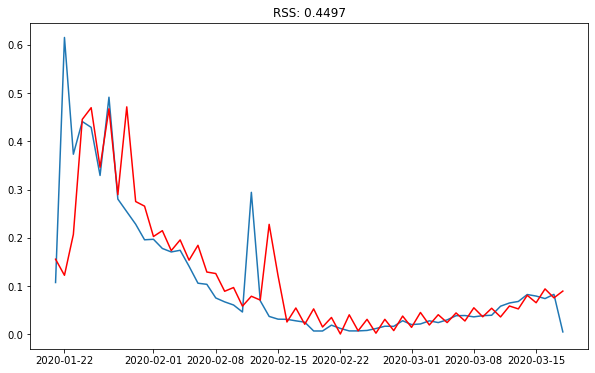

In [16]:
# AR+I+MA = ARIMA model
"""
ARIMA模型有三个参数:p,d,q。
https://www.cnblogs.com/bradleon/p/6827109.html
p--代表预测模型中采用的时序数据本身的滞后数(lags) ,也叫做AR/Auto-Regressive项
d--代表时序数据需要进行几阶差分化，才是稳定的，也叫Integrated项。
q--代表预测模型中采用的预测误差的滞后数(lags)，也叫做MA/Moving Average项

"""

model_3 = ARIMA(indexedDataset_logScale, order=(3,1,3))
results_ARIMA = model_3.fit(disp=-1)
plt.plot(datasetLogDiffShifting_1)
plt.plot(results_ARIMA.fittedvalues, color='red')#模型数据的差分值
plt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues - datasetLogDiffShifting_1['confirmedCount'])**2))
print('Plotting ARIMA model')

#### 五、时序数据预测

In [17]:
#ARIMA拟合的其实是一阶差分ts_log_diff，predictions_ARIMA_diff[i]是第i个天与i-1个天的ts_log的差值。
#由于差分化有一阶滞后，所以第一个天的数据是空的
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff#ARIMA拟合的一阶差分值

日期
2020-01-21    0.155787
2020-01-22    0.122467
2020-01-23    0.207146
2020-01-24    0.445541
2020-01-25    0.469814
2020-01-26    0.346325
2020-01-27    0.467504
2020-01-28    0.289589
2020-01-29    0.471521
2020-01-30    0.275306
2020-01-31    0.265750
2020-02-01    0.202877
2020-02-02    0.214951
2020-02-03    0.173614
2020-02-04    0.195797
2020-02-05    0.153820
2020-02-06    0.184587
2020-02-07    0.129208
2020-02-08    0.126112
2020-02-09    0.089335
2020-02-10    0.097104
2020-02-11    0.058521
2020-02-12    0.079056
2020-02-13    0.071111
2020-02-14    0.228023
2020-02-15    0.121475
2020-02-16    0.025698
2020-02-17    0.054713
2020-02-18    0.020913
2020-02-19    0.052874
2020-02-20    0.015306
2020-02-21    0.035050
2020-02-22    0.000843
2020-02-23    0.040551
2020-02-24    0.007357
2020-02-25    0.031184
2020-02-26    0.002484
2020-02-27    0.031212
2020-02-28    0.007849
2020-02-29    0.037950
2020-03-01    0.014567
2020-03-02    0.045396
2020-03-03    0.019500
2020-03-

In [18]:
indexedDataset_logScale

,confirmedCount
日期,
2020-01-20,5.641907
2020-01-21,5.749393
2020-01-22,6.364751
2020-01-23,6.738152
2020-01-24,7.179308
2020-01-25,7.608374
2020-01-26,7.937732
2020-01-27,8.429236
2020-01-28,8.709630


In [19]:
#Convert to cumulative sum 累计和
#累加现有的diff，得到每个值与第一个天的差分（同log底的情况下）。
#即predictions_ARIMA_diff_cumsum[i] 是第i个月与第1个月的ts_log的差值。
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()

print(predictions_ARIMA_diff_cumsum)

日期
2020-01-21    0.155787
2020-01-22    0.278254
2020-01-23    0.485399
2020-01-24    0.930940
2020-01-25    1.400754
2020-01-26    1.747079
2020-01-27    2.214583
2020-01-28    2.504172
2020-01-29    2.975693
2020-01-30    3.250999
2020-01-31    3.516749
2020-02-01    3.719625
2020-02-02    3.934577
2020-02-03    4.108191
2020-02-04    4.303988
2020-02-05    4.457808
2020-02-06    4.642395
2020-02-07    4.771604
2020-02-08    4.897716
2020-02-09    4.987051
2020-02-10    5.084154
2020-02-11    5.142675
2020-02-12    5.221731
2020-02-13    5.292842
2020-02-14    5.520866
2020-02-15    5.642341
2020-02-16    5.668040
2020-02-17    5.722752
2020-02-18    5.743666
2020-02-19    5.796539
2020-02-20    5.811845
2020-02-21    5.846895
2020-02-22    5.847738
2020-02-23    5.888289
2020-02-24    5.895646
2020-02-25    5.926830
2020-02-26    5.929314
2020-02-27    5.960526
2020-02-28    5.968375
2020-02-29    6.006325
2020-03-01    6.020892
2020-03-02    6.066288
2020-03-03    6.085788
2020-03-

In [20]:
#predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff_cumsum.cumsum()

In [21]:
#先ts_log_diff => ts_log=>ts_log => ts 
#先以ts_log的第一个值作为基数，复制给所有值，然后每个时刻的值累加与第一个月对应的差值(这样就解决了，第1、2个天diff数据为空的问题了)
#然后得到了predictions_ARIMA_log => predictions_ARIMA
predictions_ARIMA_log = pd.Series(indexedDataset_logScale['confirmedCount'].iloc[0], index=indexedDataset_logScale.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

日期
2020-01-20    5.641907
2020-01-21    5.797694
2020-01-22    5.920161
2020-01-23    6.127306
2020-01-24    6.572847
dtype: float64

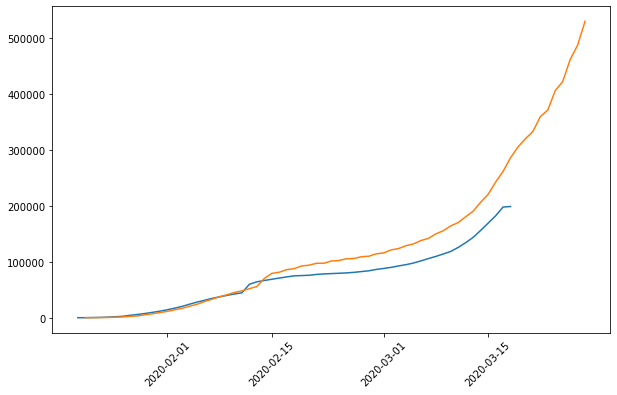

In [30]:
# Inverse of log is exp.
predictions_ARIMA = np.exp(predictions_ARIMA_log)
#predictions_ARIMA

plt.xticks(rotation=45)
plt.plot(indexedDataset)
plt.plot(predictions_ARIMA)

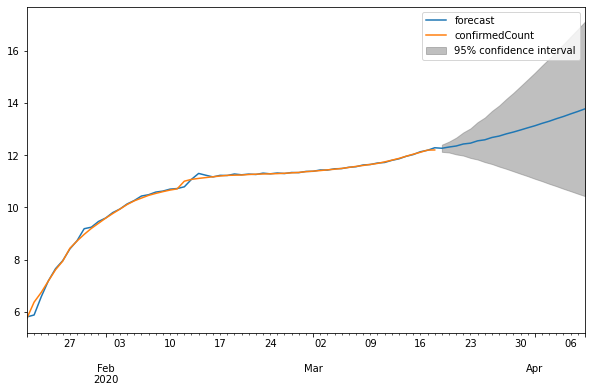

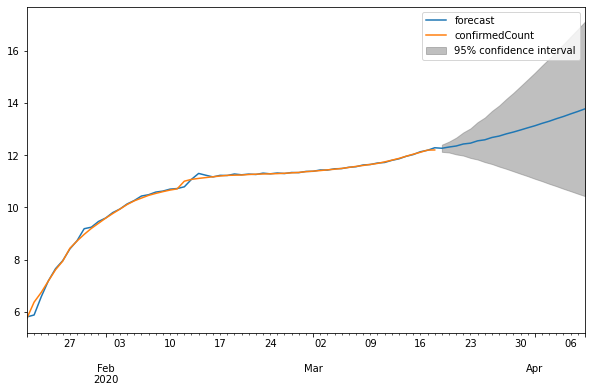

In [23]:
#We have 144(existing data of 12 yrs in months) data points. 
#And we want to forecast for additional 120 data points or 10 yrs.
results_ARIMA.plot_predict(1,79) 

In [24]:
help(results_ARIMA)


Help on ARIMAResultsWrapper in module statsmodels.tsa.arima_model object:

class ARIMAResultsWrapper(ARMAResultsWrapper)
 |  ARIMAResultsWrapper(results)
 |  
 |  Class which wraps a statsmodels estimation Results class and steps in to
 |  reattach metadata to results (if available)
 |  
 |  Method resolution order:
 |      ARIMAResultsWrapper
 |      ARMAResultsWrapper
 |      statsmodels.base.wrapper.ResultsWrapper
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  conf_int(self, alpha=0.05, cols=None, method='default')
 |      conf_int(self, alpha=0.05, cols=None, method='default')
 |      
 |      Returns the confidence interval of the fitted parameters.
 |      
 |      Parameters
 |      ----------
 |      alpha : float, optional
 |          The significance level for the confidence interval.
 |          ie., The default `alpha` = .05 returns a 95% confidence interval.
 |      cols : array-like, optional
 |          `cols` specifies which confidence intervals to retu

In [25]:
predictions_ARIMA_=results_ARIMA.predict(1,68)#取68天的预测结果


predictions_ARIMA_diff = pd.Series(predictions_ARIMA_, copy=True)
predictions_ARIMA_diff#ARIMA拟合的一阶差分值
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()


#先ts_log_diff => ts_log=>ts_log => ts 
#先以ts_log的第一个值作为基数，复制给所有值，然后每个时刻的值累加与第一个月对应的差值(这样就解决了，第1、2个天diff数据为空的问题了)
#然后得到了predictions_ARIMA_log => predictions_ARIMA
predictions_ARIMA_log = pd.Series(indexedDataset_logScale['confirmedCount'].iloc[0], index=predictions_ARIMA_.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)

# Inverse of log is exp.
predictions_ARIMA = np.exp(predictions_ARIMA_log)
print(predictions_ARIMA)


2020-01-21       329.538778
2020-01-22       372.471572
2020-01-23       458.200273
2020-01-24       715.403767
2020-01-25      1144.429454
                  ...      
2020-03-24    406368.234220
2020-03-25    422596.453651
2020-03-26    462061.463898
2020-03-27    487695.028732
2020-03-28    530574.099101
Freq: D, Length: 68, dtype: float64


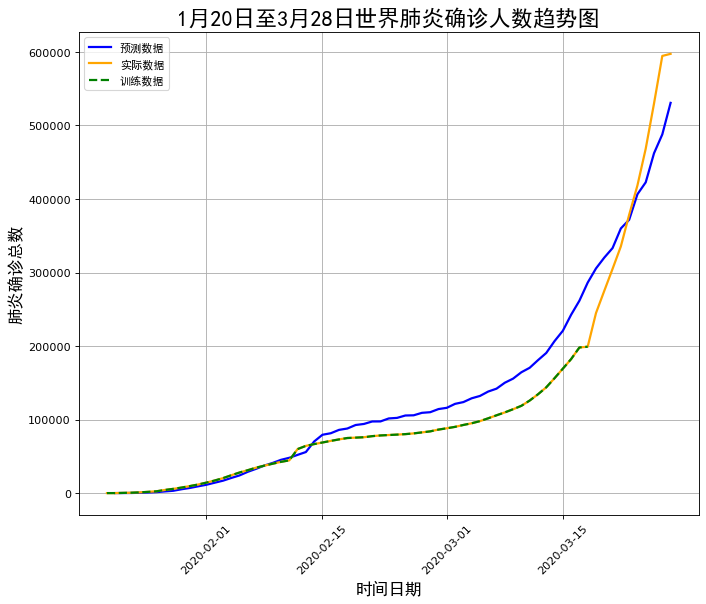

In [26]:
Data1 = pd.read_csv('./world0120-0328.csv', index_col=0)#1月20日-3月28日 世界总确诊人数
#增加id递增列
#增加id递增列

Data1 = Data1.reset_index()
Data1['日期']= pd.to_datetime(Data1['日期'],infer_datetime_format=True) 
#set_index( ) 将 DataFrame 中的列转化为行索引
indexedDataset_original = Data1.set_index(['日期'])

#数据反转
indexedDataset_original = indexedDataset_original.iloc[::-1]



from matplotlib import font_manager

my_font = font_manager.FontProperties(fname="C:/Windows/Fonts/simhei.ttf")#黑体
plt.figure(figsize=(10,8),dpi = 80)
plt.xticks(rotation=45,fontsize=10)
plt.yticks(fontsize=10)

plt.plot(predictions_ARIMA,markersize=30,label='预测数据',color = 'blue',linewidth=2.0)#1月20日-3月28日 世界总确诊人数预测曲线
plt.plot(indexedDataset_original,markersize=30,label='实际数据',color = 'orange',linewidth=2.0)#1月20日-3月28日 世界总确诊人数实际曲线
plt.plot(indexedDataset,markersize=30,label='训练数据',color = 'green',linestyle='--',linewidth=2.0)#1月20日-3月18日 世界总确诊人数训练集曲线

##添加描述信息
plt.xlabel("时间日期",fontproperties = my_font,fontsize=15)
plt.ylabel("肺炎确诊总数",fontproperties = my_font,fontsize=15)
plt.title("1月20日至3月28日世界肺炎确诊人数趋势图",fontproperties = my_font,fontsize=20)
plt.grid(alpha=1) #网格线的透明程度  数值越大，网格颜色越深
## 添加图例
#############################待解决问题：为何我的图例 不会变大！！！！############################
plt.legend(prop = my_font,loc="upper left")
#plt.savefig('figure.eps')
plt.show()

In [ ]:
https://www.bilibili.com/video/BV1Vp4y1C7Rr

In [27]:
results_ARIMA.fittedvalues

日期
2020-01-21    0.155787
2020-01-22    0.122467
2020-01-23    0.207146
2020-01-24    0.445541
2020-01-25    0.469814
2020-01-26    0.346325
2020-01-27    0.467504
2020-01-28    0.289589
2020-01-29    0.471521
2020-01-30    0.275306
2020-01-31    0.265750
2020-02-01    0.202877
2020-02-02    0.214951
2020-02-03    0.173614
2020-02-04    0.195797
2020-02-05    0.153820
2020-02-06    0.184587
2020-02-07    0.129208
2020-02-08    0.126112
2020-02-09    0.089335
2020-02-10    0.097104
2020-02-11    0.058521
2020-02-12    0.079056
2020-02-13    0.071111
2020-02-14    0.228023
2020-02-15    0.121475
2020-02-16    0.025698
2020-02-17    0.054713
2020-02-18    0.020913
2020-02-19    0.052874
2020-02-20    0.015306
2020-02-21    0.035050
2020-02-22    0.000843
2020-02-23    0.040551
2020-02-24    0.007357
2020-02-25    0.031184
2020-02-26    0.002484
2020-02-27    0.031212
2020-02-28    0.007849
2020-02-29    0.037950
2020-03-01    0.014567
2020-03-02    0.045396
2020-03-03    0.019500
2020-03-

In [28]:
results_ARIMA.predict(1,69)

2020-01-21    0.155787
2020-01-22    0.122467
2020-01-23    0.207146
2020-01-24    0.445541
2020-01-25    0.469814
                ...   
2020-03-25    0.039158
2020-03-26    0.089280
2020-03-27    0.053992
2020-03-28    0.084269
2020-03-29    0.070034
Freq: D, Length: 69, dtype: float64